# Feature Reduction Notebook

## Objectives 

The model already performs at 100% accuracy, this hypothesis seeks to discover if reducing input complexity by focusing on grayscale, improves computational efficiency without compromising on the performance required by the client of >97% accuracy.


* Answer Business Requirement 2:
    * The client is interested to know if a cherry leaf has powdery mildew or not.

## Inputs
    * inputs/cherry_leaves/cherry-leaves/train
    * inputs/cherry_leaves/cherry-leaves/test
    * inputs/cherry_leaves/cherry-leaves/validation
   

## Outputs 
* Images distribution plot in train, validation and test set
* Image augmentation and greyscale 
* Class indices to change prediction inference in labels
* Machine learning model creation and training
* Save model
* Learning curve plot for model performance
* Model evaluation on pickle file
* Prediction on the random image file
    
## Additional Comments | Insights | Conclusions
* Using greyscale the computational time for model training was cut by 60% and the accuracy was still in the client's requested range.

## Import Libraries

In [1]:
import datetime
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
import joblib

## Set Working Directory

In [2]:
current_dir = os.getcwd()
current_dir

'/workspace/P5-Mildew-Detection-in-Cherry-Leaves/jupyter_notebooks'

In [3]:
os.chdir('/workspace/P5-Mildew-Detection-in-Cherry-Leaves')
print("You set a new current directory")

You set a new current directory


In [4]:
work_dir = os.getcwd()
work_dir

'/workspace/P5-Mildew-Detection-in-Cherry-Leaves'

## Set Input Directories

In [5]:
my_data_dir = 'inputs/cherry_leaves/cherry-leaves'
test_path = my_data_dir + '/test'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'

## Set Output Directory

In [6]:
version = 'v2'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
  print('Old version is already available create a new version.')
  pass
else:
  os.makedirs(name=file_path)

Old version is already available create a new version.


## Log Directory

In [7]:
log_dir = f"outputs/{version}/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch='500,520')

2025-01-09 10:27:16.323380: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2025-01-09 10:27:16.323410: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2025-01-09 10:27:16.323638: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


### Set labels

In [8]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
    )

Project Labels: ['healthy', 'powdery_mildew']


### Set Greyscale image shape

In [9]:
image_shape = (256, 256, 1)  # Grayscale shape
joblib.dump(value=image_shape, filename=f"{file_path}/image_shape.pkl")

['outputs/v2/image_shape.pkl']

### Data Distribution Visualisation 

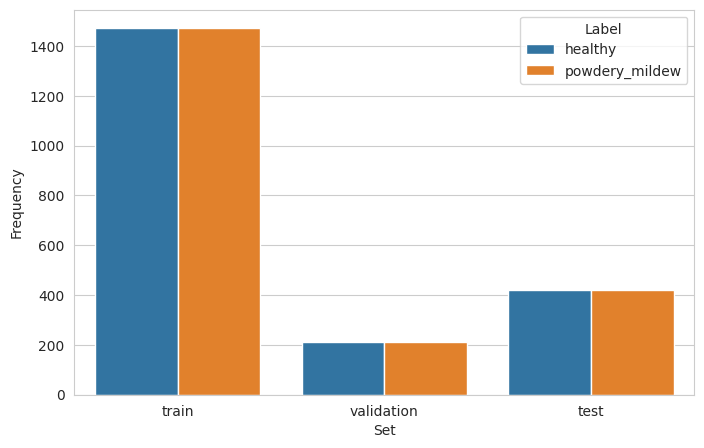

In [ ]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

## Image Data Augmentation

### Augmentation for Greyscale creation

In [11]:
batch_size = 20
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255)

train_set = augmented_image_data.flow_from_directory(train_path,
                                                      target_size=image_shape[:2],
                                                      color_mode='grayscale',
                                                      batch_size=batch_size,
                                                      class_mode='binary',
                                                      shuffle=True)

validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='grayscale',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False)

test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='grayscale',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False)

Found 2944 images belonging to 2 classes.
Found 420 images belonging to 2 classes.
Found 844 images belonging to 2 classes.


(20, 256, 256, 1)


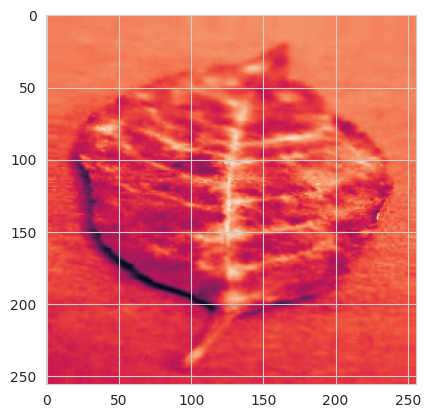

(20, 256, 256, 1)


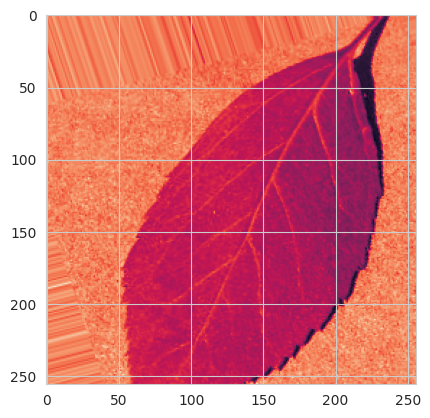

(20, 256, 256, 1)


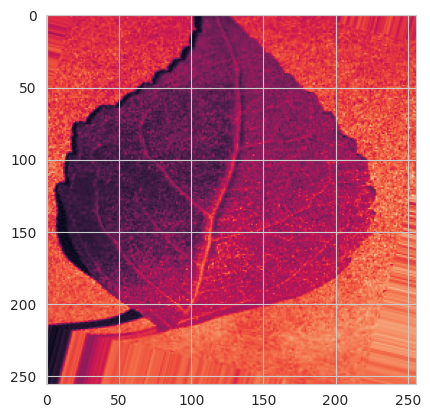

In [12]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Save class indices

In [13]:
joblib.dump(value=train_set.class_indices, filename=f"{file_path}/class_indices.pkl")

['outputs/v2/class_indices.pkl']

## Model Creation

### Define Model

Define the model using layers (the layers repeat to progressively extract more complex and higher-level features from the input data).

In [14]:
def create_tf_model_grayscale():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

### Initialise Model

In [15]:
model = create_tf_model_grayscale()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0

2025-01-09 10:31:12.691768: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Set Early Stopping

In [16]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

### Train Model

In [17]:
history = model.fit(train_set,
                    epochs=25,
                    steps_per_epoch=len(train_set.classes) // batch_size,
                    validation_data=validation_set,
                    callbacks=[early_stop, tensorboard_callback],
                    verbose=1)

2025-01-09 10:31:26.910403: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


147/147 [==============================] - 269s 2s/step - loss: 0.3491 - accuracy: 0.8331 - val_loss: 0.1388 - val_accuracy: 0.9595


2025-01-09 10:35:55.649748: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1769472000 exceeds 10% of free system memory.


Epoch 2/25
147/147 [==============================] - 264s 2s/step - loss: 0.0935 - accuracy: 0.9713 - val_loss: 0.0731 - val_accuracy: 0.9810


2025-01-09 10:40:20.649588: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1769472000 exceeds 10% of free system memory.


Epoch 3/25
147/147 [==============================] - 262s 2s/step - loss: 0.0503 - accuracy: 0.9867 - val_loss: 0.0055 - val_accuracy: 0.9976


2025-01-09 10:44:44.163271: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1769472000 exceeds 10% of free system memory.


Epoch 4/25
 58/147 [==========>...................] - ETA: 2:34 - loss: 0.0461 - accuracy: 0.9836

2025-01-09 10:46:26.159060: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2025-01-09 10:46:26.159094: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 79/147 [===============>..............] - ETA: 1:57 - loss: 0.0385 - accuracy: 0.9867

2025-01-09 10:47:02.485835: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2025-01-09 10:47:02.491670: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2025-01-09 10:47:02.502974: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: outputs/v2/logs/fit/20250109-102716/train/plugins/profile/2025_01_09_10_47_02

2025-01-09 10:47:02.511569: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to outputs/v2/logs/fit/20250109-102716/train/plugins/profile/2025_01_09_10_47_02/katherineho-p5mildewdet-i0djt8i48ey.trace.json.gz
2025-01-09 10:47:02.519425: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: outputs/v2/logs/fit/20250109-102716/train/plugins/profile/2025_01_09_10_47_02

2025-01-09 10:47:02.519554: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz

147/147 [==============================] - 262s 2s/step - loss: 0.0380 - accuracy: 0.9860 - val_loss: 0.0056 - val_accuracy: 0.9976


2025-01-09 10:49:07.949732: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1769472000 exceeds 10% of free system memory.


Epoch 5/25
147/147 [==============================] - 265s 2s/step - loss: 0.0558 - accuracy: 0.9826 - val_loss: 0.0037 - val_accuracy: 0.9976


2025-01-09 10:53:34.667074: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1769472000 exceeds 10% of free system memory.


Epoch 6/25
147/147 [==============================] - 262s 2s/step - loss: 0.0327 - accuracy: 0.9887 - val_loss: 8.6441e-04 - val_accuracy: 1.0000
Epoch 7/25
147/147 [==============================] - 263s 2s/step - loss: 0.0348 - accuracy: 0.9867 - val_loss: 0.0055 - val_accuracy: 0.9976
Epoch 8/25
147/147 [==============================] - 267s 2s/step - loss: 0.0439 - accuracy: 0.9871 - val_loss: 0.0278 - val_accuracy: 0.9929
Epoch 9/25
147/147 [==============================] - 261s 2s/step - loss: 0.0311 - accuracy: 0.9915 - val_loss: 8.8295e-04 - val_accuracy: 1.0000


### Save Model

In [18]:
model.save(f'{file_path}/cherry_leaves_model_grayscale.h5')
print(f"TensorBoard logs saved to: {log_dir}")

TensorBoard logs saved to: outputs/v2/logs/fit/20250109-102716


### Plot Training Results

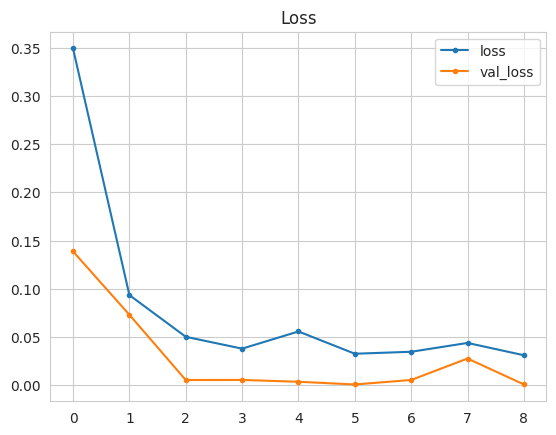

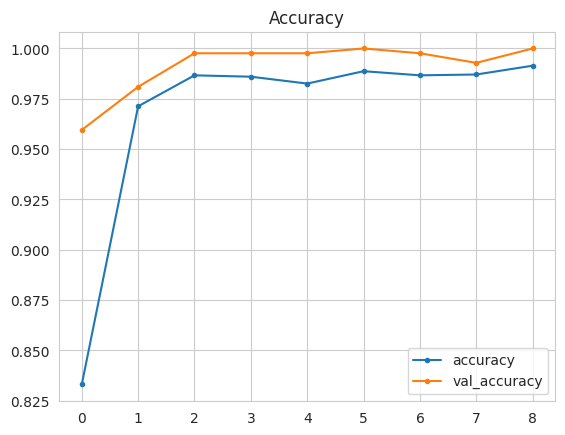

In [20]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss','val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy','val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

In [11]:
!cat gitignore

cat: gitignore: No such file or directory


In [17]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   FeatureReduction.ipynb
	modified:   ../requirements.txt

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	../outputs/v2/logs/fit/20250109-102716/
	../outputs/v2/model_training_acc.png
	../outputs/v2/model_training_losses.png

no changes added to commit (use "git add" and/or "git commit -a")


In [14]:
!git add .

In [15]:
!git commit -am " Add feature reduction model"

[main 7a0c94f]  Add feature reduction model
 2 files changed, 75 insertions(+), 18 deletions(-)


In [16]:
!git push

Enumerating objects: 9, done.
Counting objects: 100% (9/9), done.
Delta compression using up to 32 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (5/5), 1.50 KiB | 117.00 KiB/s, done.
Total 5 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/Katherine-Holland/P5-Mildew-Detection-in-Cherry-Leaves.git
   ca89217..7a0c94f  main -> main


In [8]:
%load_ext tensorboard
%tensorboard --logdir=logs

In [23]:
%reload_ext tensorboard